In [ ]:
!apt update
!apt install ffmpeg libsm6 libxext6 -y
!pip install opencv-python
!pip install --upgrade pip


Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:3 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:4 http://deb.debian.org/debian buster/main amd64 Packages [7,907 kB]
Get:5 http://deb.debian.org/debian buster-updates/main amd64 Packages [15.2 kB]
Get:6 http://security.debian.org/debian-security buster/updates/main amd64 Packages [305 kB]
Fetched 8,466 kB in 2s (5,016 kB/s)



10 packages can be upgraded. Run 'apt list --upgradable' to see them.



libsm6 is already the newest version (2:1.2.3-1).
libsm6 set to manually installed.
libxext6 is already the newest version (2:1.3.3-1+b2).
libxext6 set to manually installed.
The following additional packages will be installed:
  i965-va-driver intel-media-va-driver libaacs0 libaom0 libasound2
  libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58 libavdevice58
  libavfilter7 libavformat58 libavresample4 libavutil5

# Assignment 3 - Supervised classification applied on traffic data 
<hr>

Traffic congestion is everywhere. Here, we provide three different perspectives of a congestion - traveler's, traffic at a given moment mapped on a GIS map and in the form of a space-time speed map (space-time map is explained in the video). 
<img src="traffic jam.png">

There are different kinds of traffic congestions, which could be attributed to different causes. For example, if somebody makes a sudden break at a highway, it can create the first pattern given below whereas the second pattern is the congestion caused because of a huge fire near the Schipol tunnel in 2017.
<img src="examples.png">

Thus, if we can group these different types of congestion and add context to these groups, we can use it for diagnostic and prediction purposes. For eg. if all the patterns in a group are caused by heavy rainfall, we can classify them. Thus, given the current traffic state and the weather, we can predict how the congestion will evolve and hence mitigate them. But for this, we first need to classify. In literature, the congestion are mainly categorised into 6 groups and hence the data is also manually classified into these 6 classes. And you are going to build a classifier for these congestion types in this assignment.

## Data


The speed and flow data is collected from the A13 highway corridor in the Netherlands using loop detectors for the months of October from 2012 to 2020. We estimate the travel time for the corridor from speed and flow. The speed and flow data has been used during the course and for the assignment, you will be working with the travel time. The structure of the pandas dataframe is as follows:

- **id**: pattern id
- **date**: measurement date
- **speed**: speed matrix of size space X time, speed is measured every 30 seconds
- **flow**: flow matrix of size space X time, flow is measured every 30 seconds
- **space**: relative distance of the highway corridor sampled every 200 meters
- **time**: measurement time resolution of speed and flow
- **travel_time**: estimated travel time of the corridor at specific time
- **travel_time_time**: time resolution of estimated travel time
- **label**: manually classified label of the congestion patterns

The relevant features are date, travel_time, travel_time_time, label

NOTE: The manual classification was done based on the speed matrix. The time aggregation of the travel time data is different from the aggregation of the speed and flow data. Account for this if you use speed and flow for your analysis.

<img src="input.png">

## Instruction

The tasks are defined in each section. 
- Implement the solutions using code cells and write your analysis using markdown cells. 
- Once you have completed everything, remember to restart the kernel and run all cells again. Make sure there are no errors. 
- Save the notebook (replace XX in the filename with your group number). 
- Export a HTML version of the notebook. Hint: Menu -> File -> Download as -> HTML. 
- Submit both the notebook (.ipynb) and the export (.html)

## Justify all you answers with code or visualisations or numbers! Max 200 words per answer!

<hr>

In [ ]:
!apt update
!apt install ffmpeg libsm6 libxext6 -y
!pip install opencv-python
!pip install --upgrade pip

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease



10 packages can be upgraded. Run 'apt list --upgradable' to see them.



ffmpeg is already the newest version (7:4.1.6-1~deb10u1).
libsm6 is already the newest version (2:1.2.3-1).
libxext6 is already the newest version (2:1.3.3-1+b2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [ ]:
#all library imports
%matplotlib inline

import pandas as pd
import os
os.sys.path
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from scipy import fft
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import LeaveOneOut

Text(0.5, 1.0, 'Travel Time')

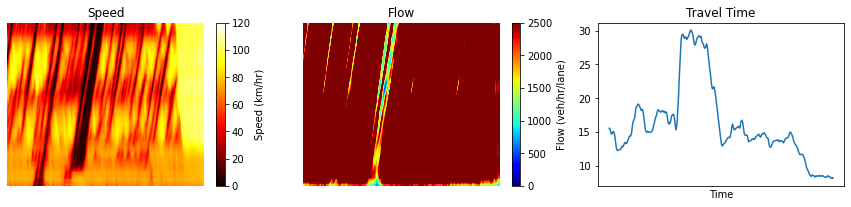

In [ ]:
#Reading the input and some visualisation code
dataset = pd.read_pickle('Assignment3_dataset_october')
fig, ax = plt.subplots(1,3, figsize=(15,3))
index = 0

im = ax[0].imshow(dataset.iloc[index].speed, cmap=plt.get_cmap('hot'), aspect="auto", vmin=0, vmax=120)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Speed (km/hr)', rotation=90)
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[0].axis('off')
ax[0].set_title('Speed')

im = ax[1].imshow(dataset.iloc[index].flow, cmap=plt.get_cmap('jet'), aspect="auto", vmin=0, vmax=2500)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Flow (veh/hr/lane)', rotation=90)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[1].axis('off')
ax[1].set_title('Flow')

im = ax[2].plot(dataset.iloc[index].travel_time_time, dataset.iloc[index].travel_time)
ax[2].set_xticks([])
ax[2].set_xlabel('Time')
ax[2].set_title('Travel Time')

## Task 1 - Data Preprocessing

QUESTION 1: Is the raw travel time sufficient to distinguish between the six classes?
Hint: Use TSNE or LDA

      id        date                                              speed  \
0      0  2014-10-14  [[29.0, 23.0, 18.0, 21.0, 26.0, 33.0, 41.0, 43...   
1      1  2014-10-13  [[95.0, 95.0, 95.0, 95.0, 95.0, 96.0, 98.0, 98...   
2      2  2014-10-25  [[100.0, 98.0, 97.0, 98.0, 100.0, 100.0, 102.0...   
3      3  2014-10-22  [[94.0, 94.0, 96.0, 96.0, 96.0, 97.0, 97.0, 97...   
4      4  2020-10-11  [[100.0, 101.0, 101.0, 100.0, 101.0, 101.0, 10...   
..   ...         ...                                                ...   
262  262  2020-10-30  [[99.0, 100.0, 100.0, 98.0, 99.0, 99.0, 99.0, ...   
263  263  2020-10-08  [[96.0, 98.0, 99.0, 98.0, 98.0, 97.0, 98.0, 98...   
264  264  2018-10-13  [[100.0, 101.0, 102.0, 102.0, 102.0, 99.0, 99....   
265  265  2013-10-26  [[101.0, 100.0, 100.0, 100.0, 101.0, 101.0, 10...   
266  266  2013-10-19  [[99.0, 101.0, 103.0, 101.0, 101.0, 100.0, 100...   

                                                  flow  \
0    [[4238.0, 3679.0, 3227.0, 3260.0, 33

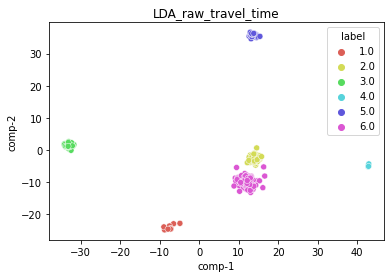

In [ ]:
#Code
dataset = pd.read_pickle('Assignment3_dataset_october')

# raw data as feature
def raw_features(data):
  data = np.array(data)
  return data.flatten()
dataset['raw_travel_time'] = dataset['travel_time'].apply(raw_features)


# the size of matrix are different size for the samples, so resize raw data 
def raw_features_resized(travel_time):
  travel_time = np.array(travel_time)
  return travel_time[:267].flatten()
dataset['raw_travel_time_resized'] = dataset['travel_time'].apply(raw_features_resized)

#LDA  
X = np.stack(dataset['raw_travel_time_resized'])
X[np.isnan(X)] = 0
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, dataset['label']).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA_raw_travel_time")
print(dataset)                

#Answer
Yes, the raw travel time sufficient to distinguish between the six classes, according to the LDA plot, the clustering of each class is pretty well, only label 2 and label 6 are close to each other which is hard to distinguish.

QUESTION 2: The travel time of a day have an aggregation of one minute. Is this time aggregation of the dataset necessary? Or can you aggregate the data further in time for the classification? 

#Answer: We think the one minute aggregation of travel ime is not necessary, and we expect that the travel time 
dataset with a time step of 30s will have a better performance. Yes we can try to aggregate by 2 min and 5 min.

QUESTION 3: Is the aggregated travel time data sufficient to distinguish between the six classes. 

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[Text(0.5, 1.0, 'LDA_raw_travel_time_aggr_2min')]

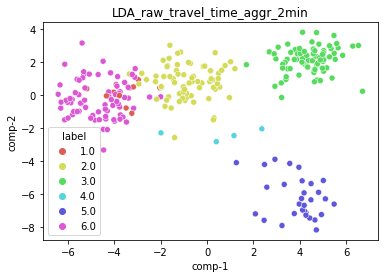

In [ ]:
#Code
# aggregation of 2 min
dataset = pd.read_pickle('Assignment3_dataset_october')
dataset['travel_time_aggr_2min']=np.zeros(267,dtype=object)
for i in range(len(dataset.travel_time)):
    list_1=dataset.iloc[i].travel_time
    if len(list_1)%2==1: #while len(list_1)%2!=0:
        list_1.pop()
    list_2=list_1[::2]
    list_3=list_1[1::2]
    list_4=[]
    for z in range(len(list_2)):
        new_value=np.mean((list_2[z],list_3[z]))
        list_4.append(new_value)

    travel_time_aggr_2min = np.zeros(176,dtype=object)
    for index in range(len(list_4)):
      travel_time_aggr_2min[index] = list_4[index]
    dataset['travel_time_aggr_2min'].iloc[i]=travel_time_aggr_2min

#print(dataset)
# raw data as feature
def raw_features(data):
  data = np.array(data)
  return data.flatten()
dataset['raw_travel_time_aggr_2min'] = dataset['travel_time_aggr_2min'].apply(raw_features)

# the size of matrix are different size for the samples, so resize raw data 
def raw_features_resized(travel_time_aggr_2min):
  travel_time_aggr_2min = np.array(travel_time_aggr_2min)
  return travel_time_aggr_2min[:267].flatten()
dataset['raw_travel_time_aggr_2min_resized'] = dataset['travel_time_aggr_2min'].apply(raw_features_resized)

for i in range(len(dataset.raw_travel_time_aggr_2min_resized)):
  if len(dataset.raw_travel_time_aggr_2min_resized.iloc[i]) != 176:
    print(i)
    print(len(dataset.raw_travel_time_aggr_2min_resized.iloc[i]))
#LDA  
X = np.stack(dataset['raw_travel_time_aggr_2min_resized'])
#X[np.isnan(X)] = 0
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, dataset['label']).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA_raw_travel_time_aggr_2min")

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[Text(0.5, 1.0, 'LDA_raw_travel_time_aggr_5min')]

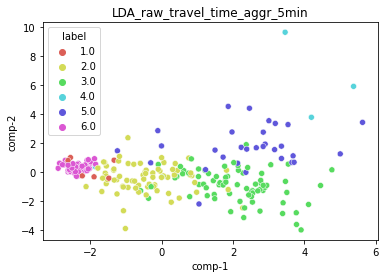

In [ ]:
#aggregation of 5 mins
dataset = pd.read_pickle('Assignment3_dataset_october')
dataset['travel_time_aggr_5min']=np.zeros(267,dtype=object)
for i in range(len(dataset.travel_time)):
    list_1=dataset.iloc[i].travel_time
    n=5
    while len(list_1)%n!=0:
        list_1.pop()
    list_5=[]
    
    for z in range(len(list_1)//5):
        new_value=np.sum((list_1[5*z:5+5*z]))
        list_5.append(new_value)
        
    

    travel_time_aggr_5min = np.zeros(176,dtype=object)
    for index in range(len(list_5)): 
      travel_time_aggr_5min[index] = list_5[index]
    dataset['travel_time_aggr_5min'].iloc[i]=travel_time_aggr_5min
    

#print(dataset)
#print(len(list_5))
# raw data as feature
def raw_features(data):
  data = np.array(data)
  return data.flatten()
dataset['raw_travel_time_aggr_5min'] = dataset['travel_time_aggr_5min'].apply(raw_features)

# the size of matrix are different size for the samples, so resize raw data 
def raw_features_resized(travel_time_aggr_5min):
  travel_time_aggr_5min = np.array(travel_time_aggr_5min)
  return travel_time_aggr_5min[:267].flatten()
dataset['raw_travel_time_aggr_5min_resized'] = dataset['travel_time_aggr_5min'].apply(raw_features_resized)

for i in range(len(dataset.raw_travel_time_aggr_5min_resized)):
  if len(dataset.raw_travel_time_aggr_5min_resized.iloc[i]) != 176:
    print(i)
    print(len(dataset.raw_travel_time_aggr_5min_resized.iloc[i]))
#LDA  
X = np.stack(dataset['raw_travel_time_aggr_5min_resized'])
# X[np.isnan(X)] = 0
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, dataset['label']).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA_raw_travel_time_aggr_5min")

#Answer Comparing the LDA plots of 1,2 and 5 mins aggregation, the performance of classification is gradually decreasing. The results show that if we aggregate more, some features of the data will be lost. This is coherent with our expectation of having a lower aggregation of e.g 30s for the travel time dataset may have the best performance.

## Bonus Question - High level features

QUESTION 4: Extract high-level features from the travel time dataset using any method or detector. Visualise the output of the detector with an example travel time vector.

Text(0.5, 0, 'Detector id')

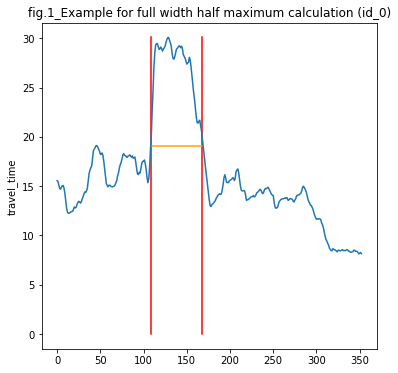

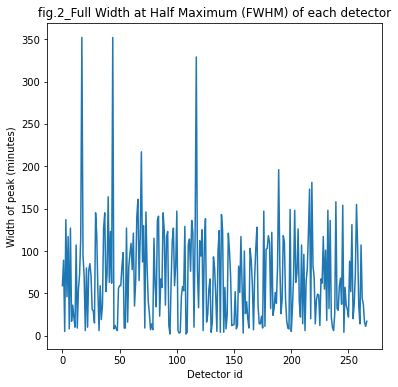

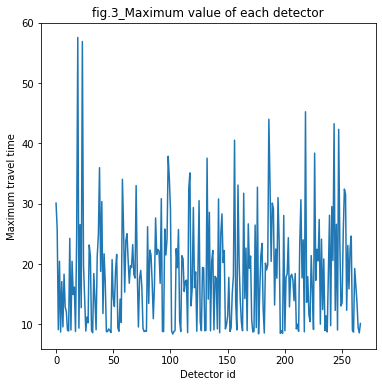

In [ ]:
#fwhm = full width at half maximum for largest peak of travel_time of each detector
#Maximum value of the travel_time data of each detector

dataset = pd.read_pickle('Assignment3_dataset_october')
# fig, ax = plt.subplots(figsize=(8,8))
# ax.plot(range(1,353), dataset.iloc[17].travel_time)
# ax.set_title('fig.1_travel_time(id_17)')
# ax.set_ylabel('travel_time')
# ax.set_xlabel('Time(minutes)')
# X = fft.fft(np.array(dataset.iloc[1].travel_time))
# ax.set_xlabel('Time (minutes)')
# print((dataset.iloc[0].travel_time_time)[352])
# fig, ax = plt.subplots(figsize=(20,8))
# plt.plot(X)

def maximum(list_or_array):
    max = 0
    for x, i in enumerate(list_or_array):
        if i > max:
            max = i
            index = x
    return index, max
list_of_maximum = np.zeros(len(dataset),dtype=object)
list_of_fwhm = np.zeros(len(dataset),dtype=object)
for q in range(len(dataset)):
    current_list=dataset.iloc[q].travel_time
    max_index, max_value = maximum(current_list)
    min_value = np.min(current_list)
    half_value = max_value - (max_value-min_value)/2
    try:
        for y in range(max_index+1,len(current_list)):
            cur_value = current_list[y]
            next_value = current_list[y+1]
            if cur_value >= half_value and next_value <= half_value:
                break
            elif y == len(current_list)-1:
                print('error')
    except IndexError:
        y = None
    right = y 
    
    for z in range(max_index-1, 0,-1):
        cur_value = current_list[z]
        next_value = current_list[z-1]
        if cur_value >= half_value and next_value <= half_value:
            break
    if q == 0:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.plot([z,z],[0,max_value],color='red')
        ax.plot([y,y],[0,max_value], color='red')
        ax.plot([y,z],[half_value,half_value],color='orange', label = 'full width at half maximum')
        ax.set_ylabel('travel_time')
        ax.set_title('fig.1_Example for full width half maximum calculation (id_0)')
        ax.plot(current_list)
    left = z
    if max_index == 0: # if we cannot find a left boundary assume width in right and left value are equal
        fwhm = right*2
    elif y == None:
        fwhm = left*2
    else:
        fwhm = right-left #else we take the difference
    if fwhm > len(current_list):
        fwhm = len(current_list)
    list_of_fwhm[q] = fwhm
    list_of_maximum[q] = max_value

# print(list_of_fwhm)
# print(list_of_maximum)
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(list_of_fwhm)
ax.set_title('fig.2_Full Width at Half Maximum (FWHM) of each detector')
ax.set_ylabel('Width of peak (minutes)')
ax.set_xlabel('Detector id')
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(list_of_maximum)
ax.set_title('fig.3_Maximum value of each detector')
ax.set_ylabel('Maximum travel time')
ax.set_xlabel('Detector id')

#Answer 
We choose "the maximum value of travel time of each detector" and "the full width at half maximum for largest peak of travel_time of each detector" as two high-level features. \
Figure 1 shows an example of full width half maximum calculation(detector 0), first let the maximum value minus minimum value of travel time of detector 0 and divided by two and get the half value which is the orange line in Figure 2. The orange line also indicates the width of the maximum travel time which can be known as the "peak duration". In this example, detector 0 has an FWHM of around 50 minutes.\
Figure 2 shows the Full Width at Half Maximum (FWHM) of each detector, as you can see at detector_id=0, the width of peak will be around 50 minutes.\
Figure 3 shows the Maximum value of each detector.


QUESTION 5: Is the high-level features sufficient to distinguish between the six classes. 

[Text(0.5, 1.0, 'LDA_fwhm_maximum')]

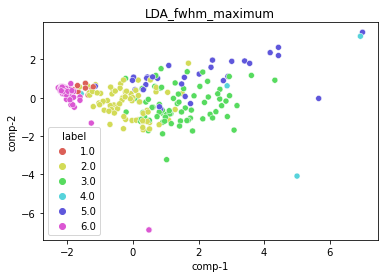

In [ ]:
#Code
#use LDA on question 4
dataset = pd.read_pickle('Assignment3_dataset_october')

dataset['fwhm']=list_of_fwhm
dataset['maximum']=list_of_maximum



def combine(row):
    fwhm = row['fwhm']/350
    maximum = row['maximum']/60
    return np.array([fwhm, maximum]).flatten()
dataset['combine'] = dataset[['fwhm','maximum']].apply(combine, axis=1)

#print(dataset)
 
#Compare LDA results between raw speed, combined speed + flow and aggregated speed  
X = np.stack(dataset['combine'])
X[np.isnan(X)] = 0
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, dataset['label']).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA_fwhm_maximum")


Answer Although some classes do not mix, it is evident that e.g. class 5 cannot be distinguished from class 3.
Therefore, the two features that were chosen are not good enough to distinguish between the classes. However, one could try to add more high level features to make distinguish even better. Examples could be the number of peaks or an averaged fwhm for multiple peaks. 

## Task 2 - Probablistic Classifier

QUESTION 6: Divide the dataset into test, train and validation dataset. Build a logistic classifier for the dataset. Use leave-one-out validation strategy for the classifier. Justify the parameter selection

In [ ]:
df = pd.read_pickle('Assignment3_dataset_october')
def resize_features(data):
    x = cv2.resize(np.array(data), (100,100)).flatten()
    return x
df['resize_travel_time'] = df['travel_time'].apply(resize_features)
X_data = np.stack(df['resize_travel_time'])

Y_data = np.array(df['label'])

In [ ]:
#Codefrom sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
rand_seed = 1
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.7, stratify=Y_data, random_state=rand_seed)
#X_validate, X_test, Y_validate, Y_test = train_test_split(_X, _Y, test_size=0.5, stratify=_Y, random_state=rand_seed)


In [ ]:
from sklearn.linear_model import LogisticRegression
cv = LeaveOneOut()
model = LogisticRegression(C=1e5, max_iter=1000)
scores_cross = cross_val_score(model, X_train,Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_cross = abs(scores_cross)

model.fit(X_train, Y_train)
result = model.score(X_test, Y_test)

THe parameters for the LogisticRegression are: C which is set at 1E5 and max iterations at 1000. This numberof iterations is enough as convergence is obtained. The default setting for this model is lbfgs which is a solver used for multiclass problems such as this.

QUESTION 7: Evaluate the classification results with atleast 2 metrics. Justify your choice of metric.  

MAE: 0.625 (1.133)
Accuracy: 64.706%
F1 Score:  0.40093153237074985
Precision Score:  0.39809368191721134
Recall Score:  0.4069641609264251


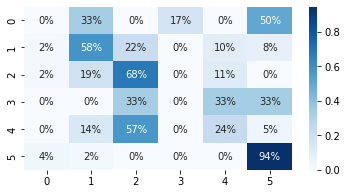

In [ ]:
#Question 7
print('MAE: %.3f (%.3f)' % (np.mean(scores_cross), np.std(scores_cross)))


print("Accuracy: %.3f%%" % (result*100.0))
Y_pred = model.predict(X_test)
print("F1 Score: ", f1_score(Y_test, Y_pred, average="macro"))
print("Precision Score: ", precision_score(Y_test, Y_pred, average="macro"))
print("Recall Score: ", recall_score(Y_test, Y_pred, average="macro")) 
def show_conf_matrix(y_true, y_pred):
    logreg_conf = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6, 3))
    sns.heatmap(logreg_conf, annot=True, fmt='.0%', cmap='Blues')
    plt.show()
show_conf_matrix(Y_test, Y_pred)




Initially, the choice of metrics are the MAE and the accuracy. These are the cross validation score and the accuracy respectively of the Leave One Out model. As can be seen the MAE has a value of 0.625 (min 0, max 1) and the accuracy is 64.7 (out of max 100%). The error and accuracy are not very high with respect to their maximum values, and there is definitely room for improvement. However, when analysing further using the confusion matrix, it can be seen that that the classification performs rather poorly for class 1, 4 and 5 (index 0, 3 and 4). Because this insight could not be gained from the accuracy, the confusion matrix should replace the accuracy as it does not tell the full story for this data.

QUESTION 8: Comment on the statistics of the probabilities in majority and minority classes

(array([ 9.,  0., 72.,  0., 75.,  0.,  4.,  0., 30., 77.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

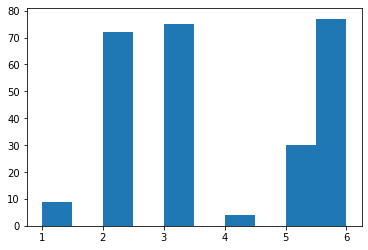

In [ ]:
plt.hist(df['label'])

The majority classes are the classes that are highly represented in the data, whereas the minority classes or not. This causes differences in the statistics of probabilities as the model can be trained better to fit for the majority classes and less for the minority classes. It is therefore likely that the errors for highly represented classes are smaller than that for lower represented classes, as is also observed in the confusion matrix (see question 7).

## Task 3 - Random Forest Classifier

QUESTION 9: Build a random forest classifier for the dataset. Use k-fold validation strategy for the classifier

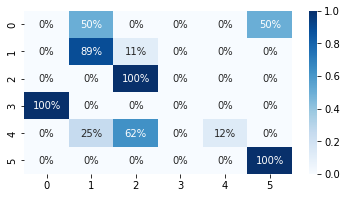

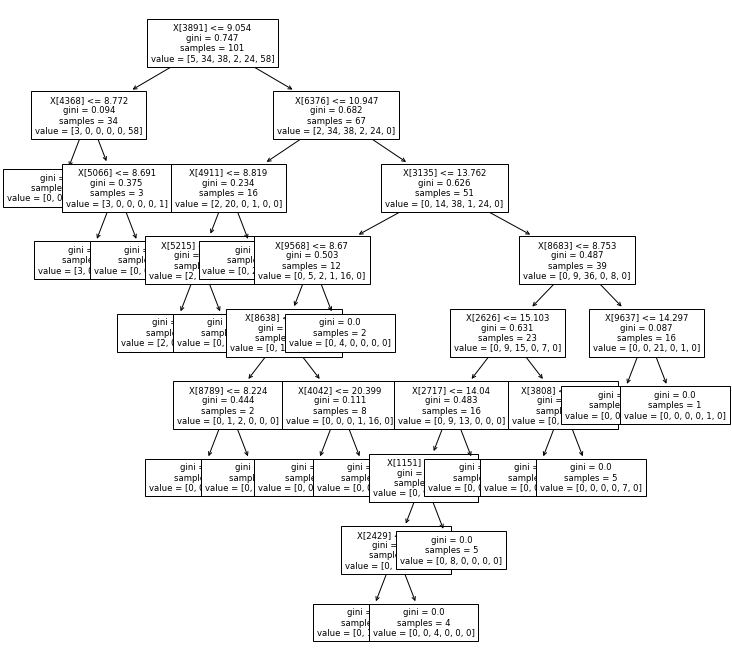

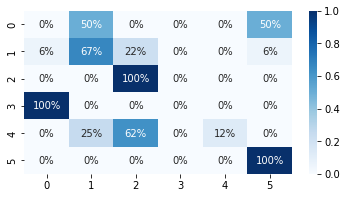

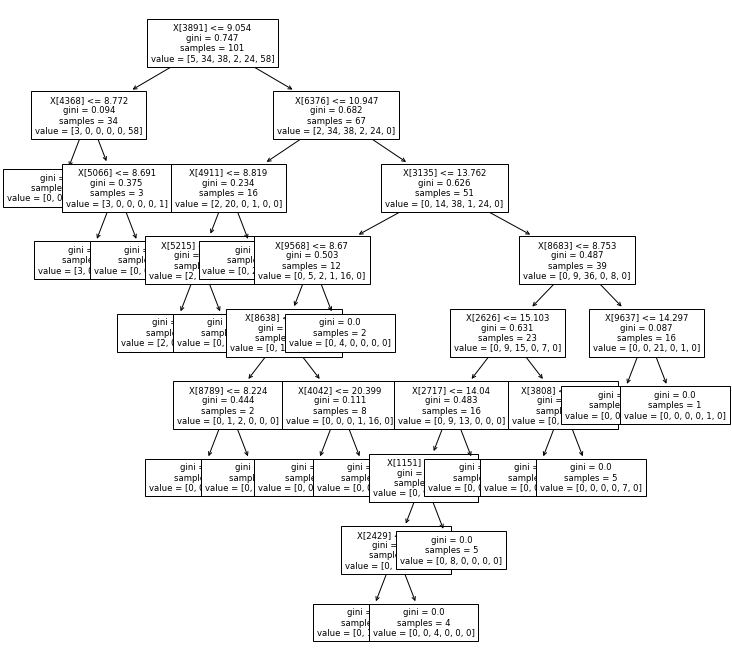

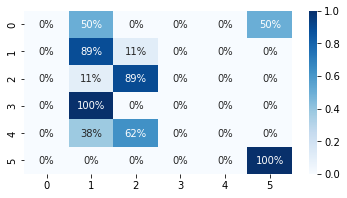

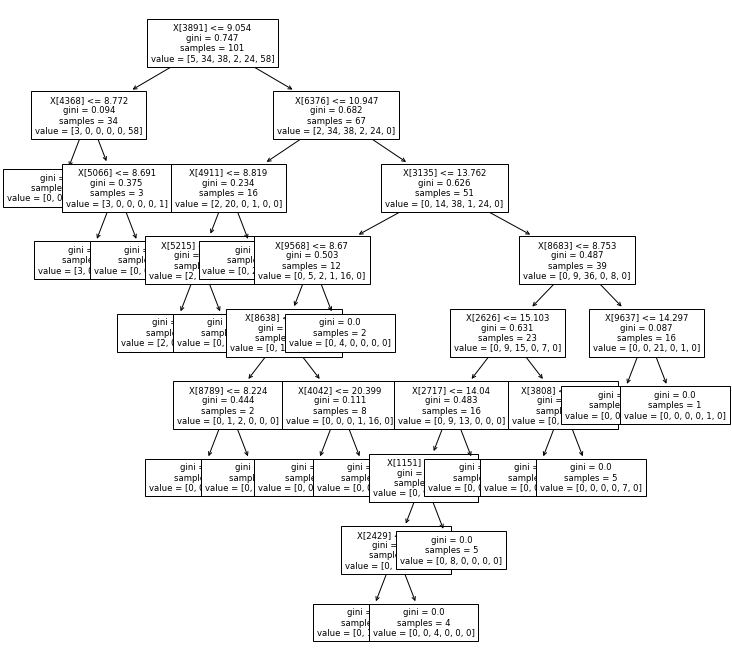

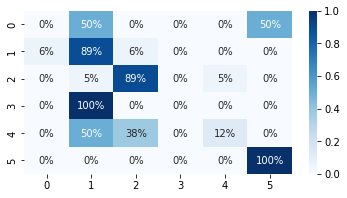

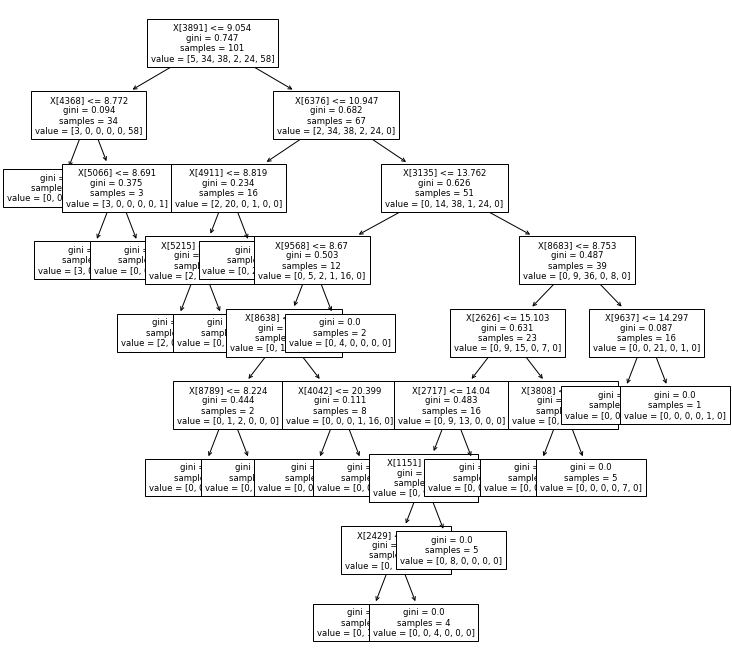

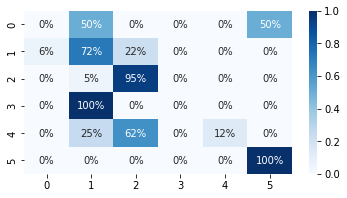

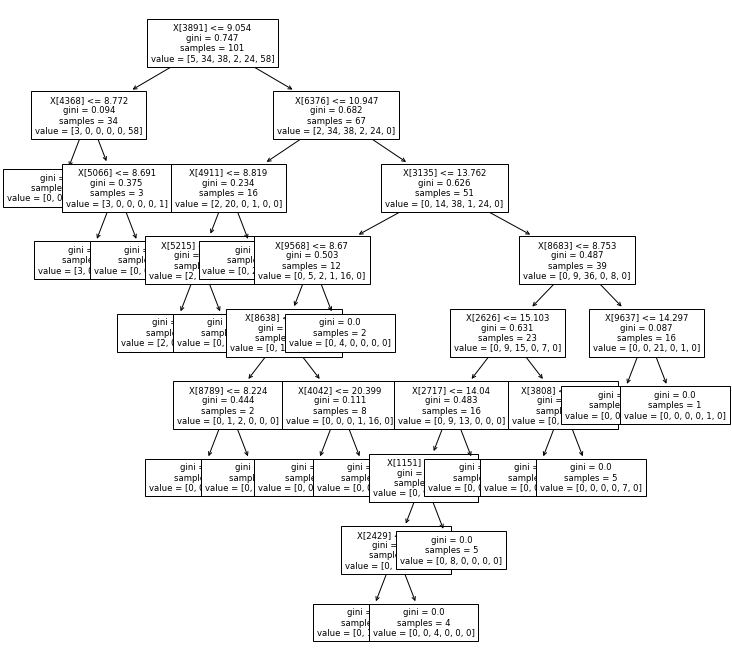

Text(0, 0.5, 'different kfolds')

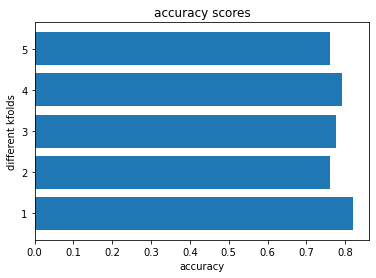

In [ ]:
#Code
from sklearn.model_selection import train_test_split
df = pd.read_pickle('Assignment3_dataset_october')

def resize_features(data):
    x = cv2.resize(np.array(data), (100,100)).flatten()
    return x
df['resize_travel_time'] = df['travel_time'].apply(resize_features)
X_data = np.stack(df['resize_travel_time'])
Y_data = np.array(df['label'])

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, stratify=Y_data, random_state=1)



def K_fold(training_data_X, training_data_Y,k=5):
    split_data_X = np.zeros(k,dtype=object)
    split_data_Y = np.zeros(k,dtype=object)
    length_data = len(training_data_X)
    #print(np.shape(training_data_X))
    #print(training_data_X)
    for i in range(k):
        split_data_X[i] = np.concatenate((training_data_X[:int(i/k*(length_data-1))], training_data_X[int((i+1)/k*(length_data-1)):]))
        split_data_Y[i] = np.concatenate((training_data_Y[:int(i/k*(length_data-1))], training_data_Y[int((i+1)/k*(length_data-1)):]))
    return split_data_X, split_data_Y

def show_conf_matrix(y_true, y_pred):
    logreg_conf = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6, 3))
    sns.heatmap(logreg_conf, annot=True, fmt='.0%', cmap='Blues')
    plt.show()

#df['raw_travel_time'] = df['travel_time'].apply(raw_features)
# print(raw_features)
#df['raw_travel_time_rescaled'] = df['raw_travel_time'].apply(rescaling, args=(max(df['raw_travel_time'].values)))

k=5
X_kfolds, Y_kfolds = K_fold(X_train,Y_train, k=k)
#print(Y_kfolds[0])

clf = RandomForestClassifier(n_estimators=100, max_depth = 70, random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, max_depth = 70, random_state=0)
clf3 = RandomForestClassifier(n_estimators=100, max_depth = 70, random_state=0)
clf4 = RandomForestClassifier(n_estimators=100, max_depth = 70, random_state=0)
clf5 = RandomForestClassifier(n_estimators=100, max_depth = 70, random_state=0)
list_of_clf = [clf, clf2, clf3, clf4, clf5]
accuracy_scores = []
for i in range(k):
    list_of_clf[i].fit(X=X_kfolds[i], y=Y_kfolds[i])
    Y_pred = list_of_clf[i].predict(X_test)
    show_conf_matrix(Y_test, Y_pred)
    plt.figure(figsize=(12,12))
    tree.plot_tree(clf.estimators_[5],fontsize=8.5)
    plt.show()
    accuracy_scores.append(accuracy_score(Y_test, Y_pred))
plt.barh(range(1,6), accuracy_scores)
plt.title('accuracy scores')
plt.xlabel('accuracy')
plt.ylabel('different kfolds')

# show_conf_matrix(Y_test, Y_pred)
# X = np.stack(df[''])



From the analysis, we see that no matter what k fold is used, the decision tree is only capable of identifying class 2, 3, and 6 consistently (75-100% hit rate) for every kfold. The first k-fold seems to be the most accurate. From time to time, class 5 is identified correctly, but this varies per k fold. After 100 runs (when not using the randomstate = 0 for RandomForestClassifier), only in four of the randomtree classifiers class 0 was detected correctly for 50%. The other class, class 3, is not identified correctly once, even after running multiple times. This is because of the imbalance in the data.

QUESTION 10: Conduct a sensitivity analysis of atleast two parameters of the random forest decision trees. Note: You dont need to find the optimal parameters but should conduct a sensitivity analysis.

Text(0, 0.5, 'Accuracy')

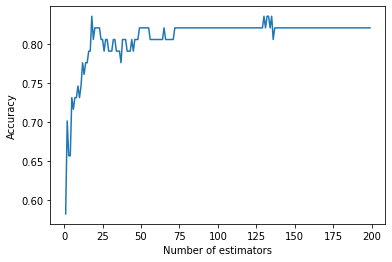

In [ ]:
#Code
# change n_estimators # change max_depth
accuracy_scores = []
for i in range(1,200):
    clf = RandomForestClassifier(n_estimators=i, max_depth = 70, random_state=0)
    clf.fit(X_kfolds[0], Y_kfolds[0])
    Ypred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(Y_test, Ypred))
plt.plot(range(1,200), accuracy_scores)
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

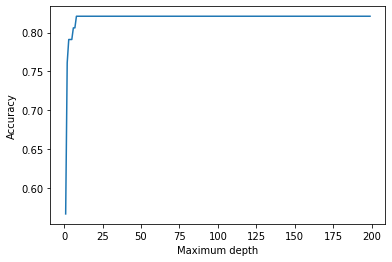

In [ ]:
accuracy_scores = []
for i in range(1,200):
    clf = RandomForestClassifier(n_estimators=100, max_depth = i, random_state=0)
    clf.fit(X_kfolds[0], Y_kfolds[0])
    Ypred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(Y_test, Ypred))
plt.plot(range(1,200), accuracy_scores)
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')

For the number of estimators, we see that the accuracy goes up initially, after which the accuracy stabilizes when more estimators are selected. This makes sense as the randomness of the tree structure becomes more averaged out when using more trees, leaving less room for randomness in the results. 
For the maximum depth, we see a rapid rise in the accuracy, followed by a stable accuracy. The stable line means that the maximum depth variable has no effect, which is caused by the tree not becoming as deep.

QUESTION 11: Analyse one of the pattern that is wrongly classified and explain why you think it is wrongly classified?

3 54 7
1 18 2


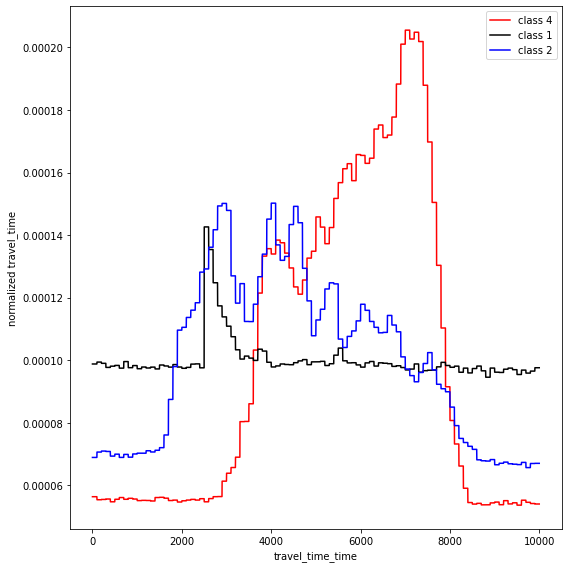

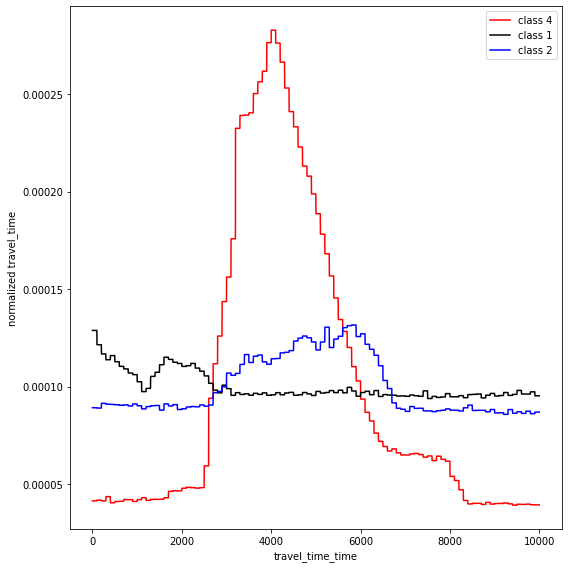

In [ ]:
#Code
counter_4 = 0
counter_1 = 0
counter_2 = 0
index_array = np.zeros(3, dtype=object)

for index, i in enumerate(Y_train):
    if i ==4:
        counter_4 += 1
        if index_array[0]==0:
            index_array[0]=[]
        index_array[0].append(index)
    elif i ==1:
        counter_1+=1
        if index_array[1]==0:
            index_array[1]=[]
        index_array[1].append(index)
    elif i ==2:
        counter_2 +=1
        if index_array[2]==0:
            index_array[2]=[]
        index_array[2].append(index)

def normalize(list_or_array):
    if type(list_or_array) == type(np.zeros(1)):
        return np.array([float(i)/np.sum(list_or_array) for i in list_or_array])
    else:
        return [float(i)/np.sum(list_or_array) for i in list_or_array]


print(counter_4,counter_2, counter_1)
counter_4 = 0
counter_1 = 0
counter_2 = 0
for i in Y_test:
    if i ==4:
        counter_4 += 1
    elif i ==1:
        counter_1+=1
    elif i ==2:
        counter_2 +=1
print(counter_4,counter_2, counter_1)
# print(Y_train)

for i in range(2):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(normalize(X_train[index_array[0][i]]), label = 'class 4', color ='red')
    ax.plot(normalize(X_train[index_array[1][i]]), label = 'class 1', color ='black')
    ax.plot(normalize(X_train[index_array[2][i]]), label = 'class 2', color ='blue')
    ax.set_ylabel('normalized travel_time')
    ax.set_xlabel('travel_time_time')
    plt.legend()
    plt.tight_layout()



#Answer
Question 9 shows that class 4 is often confused with class 1 and 2. One thing that stands out immediately is that class 4 is not abundantly represented in the training data nor in the test data. Although the class 4 is not extremely similar to class 1 or 2, the low number of data points can cause the decision trees to be underfitting for class 4 and overfitting for the class 2.

## Task 4 - Feature Importance

QUESTION 12: Visualise one of the random tree. Comment on the tree structure

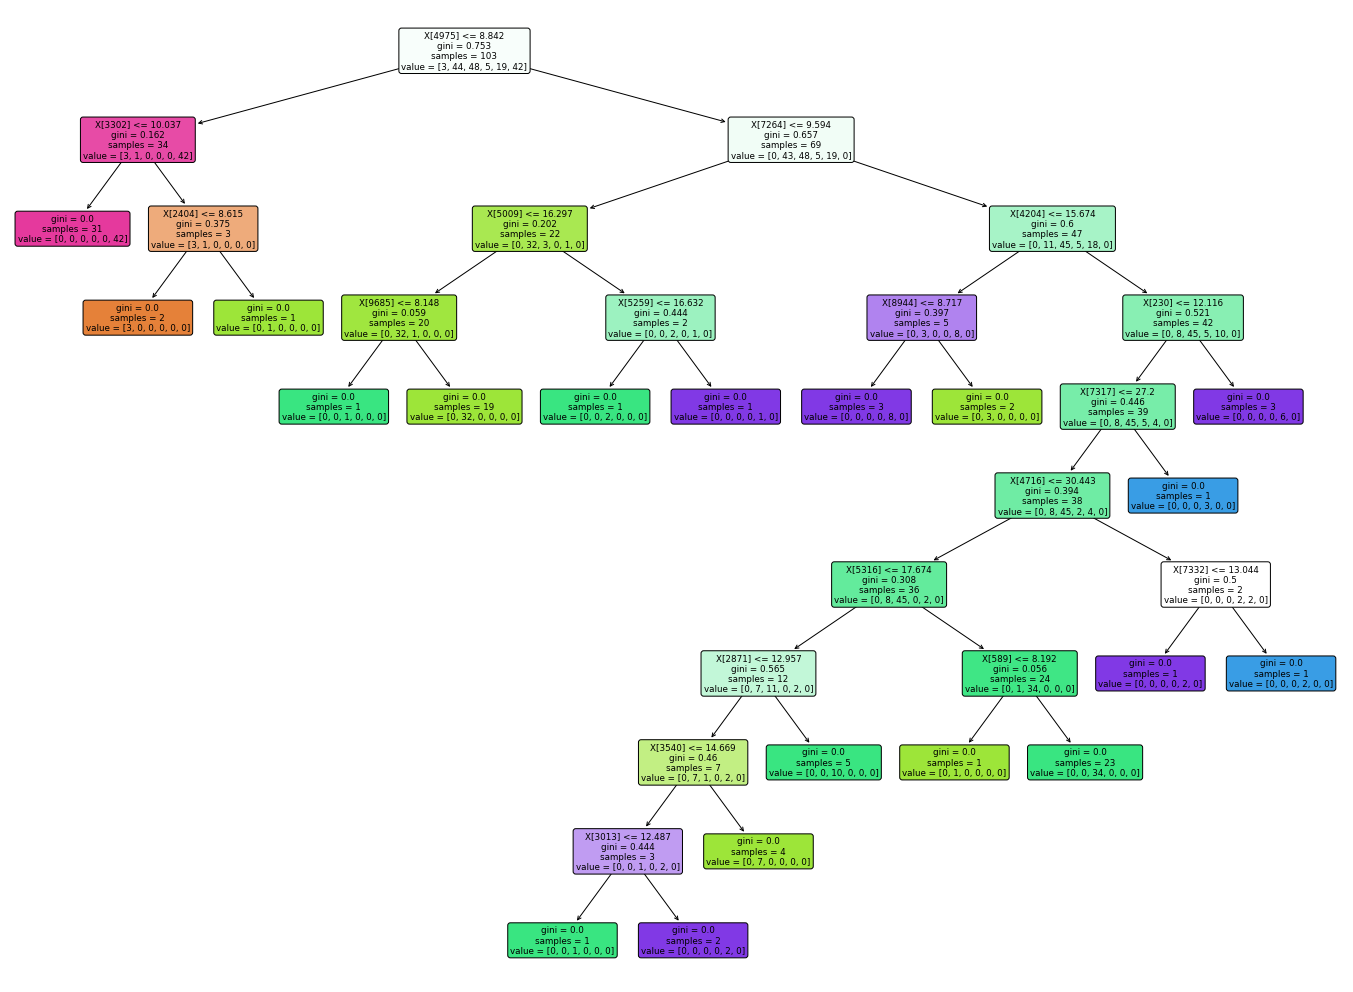

In [ ]:
#Code
# look at which features it uses (especially on top of the tree, those are important)
# determine whether it is balanced or not
# More analysis?

fig = plt.figure(figsize=(24, 18))
tree.plot_tree(clf.estimators_[0], 
          filled=True, impurity=True, 
          rounded=True)
plt.show()

#Answer Above is a visualisaion of the first decision tree from the first classifier. Here one can see that the well-performing classes (2, 3 and 6) are the leaves with a high number of samples (the two greenish leaves and the pink on respectively). This indicates that the data is imbalanced, and underperforms for the classes which are underrepresented. The tree itself is also quite imbalanced, which can mean it should be pruned at a lower depth in order to combat overfitting. If we look close to the root we can see that feature 4975 is most important, followed by feature 7264.




QUESTION 13: Analyse the random forest feature importance and comment on the findings.

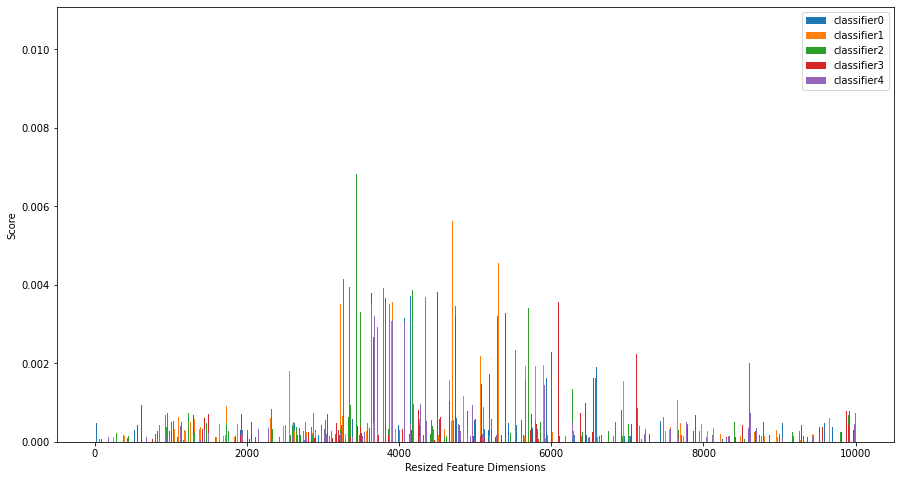

In [ ]:
#Code
#use all the trees (I think this is default)

fig = plt.figure(figsize=(15, 8))
for i, cl in enumerate(list_of_clf):
    importance = cl.feature_importances_
    plt.bar([x for x in range(len(importance))], importance, label=("classifier" + str(i)))
plt.xlabel('Resized Feature Dimensions')
plt.ylabel('Score')
plt.legend()
plt.show()

#Answer It is interesting to note the different between the feature importance of the different classifiers. Classifier 2 spikes with some important features around ~3400, while classifier 1 had a more apparent spike in importance around ~4600. This shows that training the same classifier on a different fold of the data can have a significant impact on which features it select as being most important. This makes a lot of sense with imbalanced data such as the one we are working with, because the performance of the underrepresented classes greatly depends on how they have been divided up between the training and test data.

(array([ 9.,  0., 72.,  0., 75.,  0.,  4.,  0., 30., 77.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

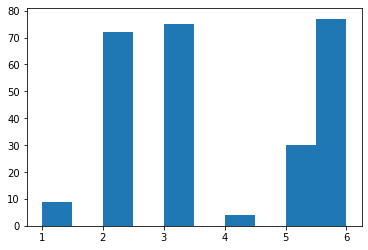

In [ ]:
# show how imbalanced the data is
plt.hist(df['label'])

## Task 5 - Reflection

QUESTION 14: Given your analysis of the data, do you consider this a supervised classification problem or do you think it can also be solved as a unsupervised learning problem. (No need of coding. Just reflect!)

We think the problem can be solved using clustering, in which we distinguish different clusters in an unsupervised manner. However, without labels we cannot identify which cluster is which. Therefore, we could call it a semi-supervised problem. It should be noted, however, that our current approach is supervised, but this does not mean the problem itself must be supervised. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=38ae55c0-42ca-490f-b159-f7777d172cbe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>